# EDX example dataset
## Introducction
EDX measurements of an $\mathrm{Mn}_{53.5}\mathrm{Al}_{43.5}\mathrm{Bi}_3$-sample that was annealed at 1100°C for 2h after being arch-melted, quenching directly in water.

In this notebook we import and analyze the data.
## Data Preview
### EDX-maps
Extracting and plotting the EDX-maps from the H5OINA file.

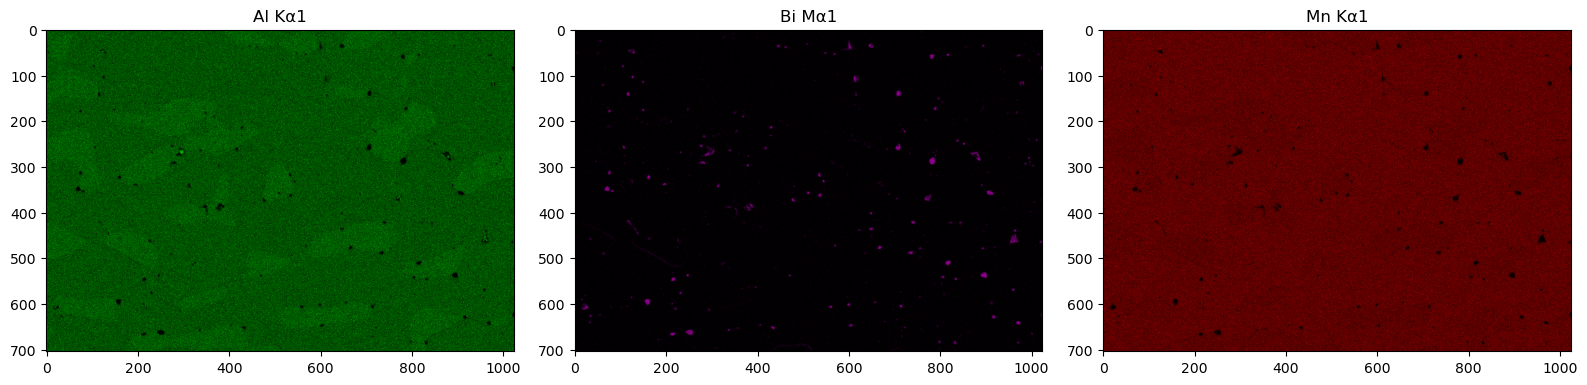

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import requests
from io import BytesIO

# dataDir = "IFW_EDX_RawData/"
# map_path = dataDir + "22632 Specimen 1 Site 1 Map Data 1.h5oina"
# upload_id = ''
# url = f'https://nomad-lab.eu/prod/v1/api/v1/uploads/{upload_id}/raw/IFW_EDX_RawData/22632 Specimen 1 Site 1 Map Data 1.h5oina'
url = 'https://keeper.mpdl.mpg.de/f/a1681b4d04b7490fa663/?dl=1'
response = requests.get(url)

#with h5py.File(map_path, 'r') as data:
with h5py.File(BytesIO(response.content), 'r') as data:
    #get shape of map, note that this will be used for a numpy array
    #so Y comes first (rows) and X second (columns)
    mapshape = [data['1/EDS/Header/Y Cells'][0],
                data['1/EDS/Header/X Cells'][0]]

    #get names of all quantified elements in this particular EDS
    #measurement, include their X-ray quanta
    elements = list(data['1/EDS/Data/Window Integral'])

    edx_maps = np.empty(shape=([len(elements)] + mapshape + [3]), dtype='uint8')
    #iterate over all quantified elements
    for i in range(len(elements)):
        #get measured counts per second of each measurement point
        if int(np.__version__[0]) < 2:
            valmap = np.reshape(data['1/EDS/Data/Window Integral'][elements[i]][:],
                            newshape=[704, 1024])
        else:
            valmap = np.reshape(data['1/EDS/Data/Window Integral'][elements[i]][:],
                            shape=[704, 1024])
        #maximum counts per second in this map
        maxval = np.max(valmap)
        #minimum counts per second in this map
        minval = np.min(valmap)
        #get color specified for this particular element from .h5oina
        color = data['1/EDS/Data/Window Integral'][elements[i]].attrs['Upper Color']

        #normalize value of current measurement point so that all
        #points have values between 0 and 1, then multiply with
        #elements color. This yields the the same color for each
        #measurement point whith its intensity scaled to the
        #points respective counts per second
        norm = (valmap - minval) / maxval

        # reshape
        colormap = np.repeat(np.expand_dims(norm, -1), 3, axis=2) * color

        #round the colormap from float32 to uint8
        colormap = np.uint8(colormap)

        edx_maps[i] = colormap

# Plot the EDX maps
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for i in range(len(elements)):
    axes[i].imshow(edx_maps[i])
    axes[i].set_title(elements[i])
fig.tight_layout()

### Individual EDX Spectra
Reading and plotting all EDX spectra from EMSA-files with an SEM scan showing positions of the points, where the spectra were measured.

In [ ]:
#Reading all spectra
allSpectra = {}
allCharEnergies = {}
urls = ['https://keeper.mpdl.mpg.de/f/6048d3e55a1a49b998e3/?dl=1',
        'https://keeper.mpdl.mpg.de/f/4413560f9dc74c139e3d/?dl=1',
        'https://keeper.mpdl.mpg.de/f/a71aea7a20d241f8b6cc/?dl=1',
        'https://keeper.mpdl.mpg.de/f/e34918f649f3480e940c/?dl=1',
        'https://keeper.mpdl.mpg.de/f/236a132063714992874b/?dl=1',
        'https://keeper.mpdl.mpg.de/f/264eabfa34a149af88a9/?dl=1',
        'https://keeper.mpdl.mpg.de/f/e28a65cdc40745e093c1/?dl=1',
        'https://keeper.mpdl.mpg.de/f/2b79935a3cea43a0984b/?dl=1',
        'https://keeper.mpdl.mpg.de/f/2c1099582dfb481b87af/?dl=1',
        'https://keeper.mpdl.mpg.de/f/ea24ac06f82f4496bd6f/?dl=1',
        'https://keeper.mpdl.mpg.de/f/8f1247da9a9e42d49deb/?dl=1',
        'https://keeper.mpdl.mpg.de/f/84b38a2c2949426a8bef/?dl=1',
        'https://keeper.mpdl.mpg.de/f/b79eb749381940db94fc/?dl=1',
        'https://keeper.mpdl.mpg.de/f/aad94f3ff1e74f4bb84a/?dl=1',
        'https://keeper.mpdl.mpg.de/f/aad94f3ff1e74f4bb84a/?dl=1'
       ]
for pointN in range(1,16):
    # url = f'https://nomad-lab.eu/prod/v1/api/v1/uploads/{upload_id}/raw/IFW_EDX_RawData/22632_ROI2_pt{pointN}_spectrum.txt'
    url = urls[pointN-1]
    response = requests.get(url)
    with open(f"22632_ROI2_pt{pointN}_spectrum.txt", "wb") as f:
        f.write(response.content)
        
for pointN in range(1,16):
    emsa = f'22632_ROI2_pt{pointN}_spectrum.txt' 
    spectrum = pd.read_csv(emsa, delimiter=',', comment='#', header=None)
    spectrum.columns = ['Energy', 'Counts']
    allSpectra[pointN] = spectrum

    with open(emsa) as f:
        head = f.read()
        head = head[head.index('OXINSTLABEL') : head.index('#SPECTRUM')]
    char_energy, elem_label = np.array([i.split() for i in head.splitlines()]).transpose()[2:4]
    char_energy = np.array([float(i[:-1]) for i in char_energy])
    allCharEnergies[pointN] = {'Energy': char_energy, 'Element': elem_label}
    # print(allCharEnergies[pointN])

#plotting all specgra with a dropdown menu
import plotly.graph_objects as go
from PIL import Image

# url = f'https://nomad-lab.eu/prod/v1/api/v1/uploads/{upload_id}/raw/IFW_EDX_RawData/data/22632_ROI2_Se_annotated.tiff'
url = 'https://keeper.mpdl.mpg.de/f/01d6dc1fd24b4e1f8bc7/?dl=1'
response = requests.get(url)
img = Image.open(BytesIO(response.content), formats=['tiff'])

#img_path = "IFW_EDX_RawData/22632_ROI2_Se_annotated.tiff"
#img = Image.open(img_path)

plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

# Create traces for all 15 spectra, all visible by default
traces = []
for n in range(1, 16):
    traces.append(go.Scatter(
        name=f'Spectrum {n}',
        x=allSpectra[n]['Energy'],
        y=allSpectra[n]['Counts'],
        visible=True  # Show all by default
    ))

# Prepare annotations for each spectrum
annotations_per_spectrum = []
for n in range(1, 16):
    ann = []
    energies = allCharEnergies[n]['Energy']
    elements = allCharEnergies[n]['Element']
    for energy, elem in zip(energies, elements):
        ann.append(dict(
            x=energy,
            y=max(allSpectra[n]['Counts']),
            xref='x',
            yref='y',
            text=elem,
            showarrow=True,
            arrowhead=1,
            ax=0,
            ay=-40,
            font=dict(color='black', size=10),
            bgcolor='rgba(255,255,255,0.7)'
        ))
    annotations_per_spectrum.append(ann)

plot = go.Figure(data=traces)

# Create dropdown buttons for all spectra and combinations
buttons = [
    dict(
        label="All",
        method="update",
        args=[
            {"visible": [True]*15},
            {"title": "All Spectra", "annotations": annotations_per_spectrum[0]}
        ]
    )
]
for n in range(1, 16):
    vis = [False]*15
    vis[n-1] = True
    buttons.append(
        dict(
            label=f"Spectrum {n}",
            method="update",
            args=[
                {"visible": vis},
                {"title": f"Spectrum {n}", "annotations": annotations_per_spectrum[n-1]}
            ]
        )
    )

plot.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=buttons
        )
    ],
    xaxis_title="Energy in eV",
    yaxis_title="Counts in cps",
    # showlegend=True
)

# Set initial annotations for all spectra (show all annotations)
plot.update_layout(annotations=annotations_per_spectrum[0])

plot.show()